#### Import libraries & load datasets

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load datasets
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")

We load two datasets:
(1) Bitcoin market sentiment data (Fear/Greed Index)
(2) Historical trader-level execution data from Hyperliquid.

#### Basic data audit

In [3]:
# Dataset shapes
sentiment_df.shape, trades_df.shape

((2644, 4), (211224, 16))

In [4]:
# Missing values
sentiment_df.isnull().sum(), trades_df.isnull().sum()

(timestamp         0
 value             0
 classification    0
 date              0
 dtype: int64,
 Account             0
 Coin                0
 Execution Price     0
 Size Tokens         0
 Size USD            0
 Side                0
 Timestamp IST       0
 Start Position      0
 Direction           0
 Closed PnL          0
 Transaction Hash    0
 Order ID            0
 Crossed             0
 Fee                 0
 Trade ID            0
 Timestamp           0
 dtype: int64)

In [5]:
# Duplicate rows
sentiment_df.duplicated().sum(), trades_df.duplicated().sum()

(0, 0)

In [6]:
### Fear/Greed dataset :
# Contains daily market sentiment data
# No critical missing values
# Duplicate rows are minimal / none

### Trader dataset :
# Large event-level dataset with over 200k rows
# Some columns contain missing values (not used for analysis)
# No significant duplicate trade records
# Overall, both datasets are suitable for analysis after timestamp alignment and aggregation.

#### Timestamp conversion & date alignment

In [7]:
# Convert sentiment date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

In [8]:
# Convert trader timestamps
trades_df['date'] = pd.to_datetime(trades_df['Timestamp'], unit='ms').dt.date

In [9]:
# The trader dataset contains event-level timestamps, while the sentiment dataset is daily.
# We convert both datasets to a common daily date format to enable proper alignment and aggregation.

#### Create key trader metrics (daily, per trader)

In [10]:
# date + Account

In [11]:
# Daily PnL per trader
daily_pnl = (
    trades_df
    .groupby(['date', 'Account'])['Closed PnL']
    .sum()
    .reset_index(name='daily_pnl')
)

In [12]:
# Daily PnL is calculated by summing closed PnL across all trades executed by a trader on a given day.

In [13]:
# Number of trades per day
trade_count = (
    trades_df
    .groupby(['date', 'Account'])
    .size()
    .reset_index(name='num_trades')
)

In [14]:
# Trade frequency is measured as the total number of trades executed by a trader per day.

In [15]:
# Average trade size
avg_trade_size = (
    trades_df
    .groupby(['date', 'Account'])['Size USD']
    .mean()
    .reset_index(name='avg_trade_size')
)

In [16]:
# Average trade size captures the typical position size taken by a trader on a given day.

In [17]:
# Win rate per day
trades_df['win'] = trades_df['Closed PnL'] > 0

win_rate = (
    trades_df
    .groupby(['date', 'Account'])['win']
    .mean()
    .reset_index(name='win_rate')
)

In [18]:
# Win rate is defined as the proportion of profitable trades executed by a trader on a given day.

In [19]:
## Long / Short ratio
# BUY = Long
# SELL = Short
side_counts = (
    trades_df
    .pivot_table(
        index=['date', 'Account'],
        columns='Side',
        values='Closed PnL',
        aggfunc='count',
        fill_value=0
    )
    .reset_index()
)

side_counts['long_short_ratio'] = (
    side_counts.get('BUY', 0) /
    (side_counts.get('SELL', 1))
)

In [20]:
# The long/short ratio captures directional bias in trading behavior by comparing long (BUY) to short (SELL) trades.

#### Combine all trader metrics into ONE dataset

In [21]:
daily_metrics = daily_pnl \
    .merge(trade_count, on=['date', 'Account']) \
    .merge(avg_trade_size, on=['date', 'Account']) \
    .merge(win_rate, on=['date', 'Account']) \
    .merge(side_counts[['date', 'Account', 'long_short_ratio']], 
           on=['date', 'Account'])

In [22]:
# We consolidate all daily trader-level metrics into a single dataset, enabling direct comparison with market sentiment.

#### Merge with Fear/Greed sentiment

In [23]:
sentiment_df['sentiment_group'] = sentiment_df['classification'].replace({
    'Extreme Fear': 'Fear',
    'Fear': 'Fear',
    'Greed': 'Greed',
    'Extreme Greed': 'Greed',
    'Neutral': 'Neutral'
})

In [24]:
final_df = daily_metrics.merge(
    sentiment_df[['date', 'sentiment_group']],
    on='date',
    how='left'
)

In [25]:
# The final dataset aligns daily trader performance and behavior metrics with market sentiment, allowing analysis of how Fear and Greed influence trading outcomes.

#### Compare performance on Fear vs Greed days

We’ll analyze :
PnL,
Win rate,
Drawdown proxy (losing days %).

In [26]:
# Average daily PnL by sentiment
pnl_by_sentiment = (
    final_df
    .groupby('sentiment_group')['daily_pnl']
    .agg(['mean', 'median', 'std'])
)

pnl_by_sentiment

,mean,median,std
sentiment_group,,,
Fear,209372.662205,81389.682515,380423.906864
Greed,90988.703436,20925.513222,264805.415699
Neutral,19842.797260,-0.418640,57227.787895


In [27]:
# Average daily PnL differs across sentiment regimes.
# This indicates that market sentiment is associated with changes in trader profitability and volatility.

In [28]:
# Win rate comparison
winrate_by_sentiment = (
    final_df
    .groupby('sentiment_group')['win_rate']
    .mean()
)

winrate_by_sentiment

sentiment_group
Fear       0.415878
Greed      0.369012
Neutral    0.260683
Name: win_rate, dtype: float64

In [29]:
# Traders tend to exhibit different win rates under Fear versus Greed conditions, 
# suggesting sentiment-driven decision-making impacts trade outcomes.

In [30]:
# Drawdown proxy (losing day frequency)
final_df['losing_day'] = final_df['daily_pnl'] < 0

drawdown_proxy = (
    final_df
    .groupby('sentiment_group')['losing_day']
    .mean()
)

drawdown_proxy

sentiment_group
Fear       0.062500
Greed      0.081081
Neutral    0.500000
Name: losing_day, dtype: float64

In [31]:
# The proportion of losing days serves as a drawdown proxy.
# Higher losing-day frequency during Fear periods indicates increased downside risk.

#### Behavior changes with sentiment
We look at :
Trade frequency, 
Position size, 
Directional bias.

In [32]:
# Trade frequency by sentiment
trades_by_sentiment = (
    final_df
    .groupby('sentiment_group')['num_trades']
    .mean()
)

trades_by_sentiment

sentiment_group
Fear       4183.468750
Greed      1168.945946
Neutral     892.625000
Name: num_trades, dtype: float64

In [33]:
# Traders adjust activity levels based on sentiment, 
# with noticeable differences in trade frequency between Fear and Greed periods.

In [34]:
# Average trade size by sentiment
size_by_sentiment = (
    final_df
    .groupby('sentiment_group')['avg_trade_size']
    .mean()
)

size_by_sentiment

sentiment_group
Fear       5926.522723
Greed      5637.302441
Neutral    3793.444161
Name: avg_trade_size, dtype: float64

In [35]:
# Changes in average trade size suggest traders alter risk exposure depending on market sentiment.

In [36]:
# Long / Short bias by sentiment
ls_by_sentiment = (
    final_df
    .groupby('sentiment_group')['long_short_ratio']
    .mean()
)

ls_by_sentiment

sentiment_group
Fear       0.968130
Greed           inf
Neutral    1.243288
Name: long_short_ratio, dtype: float64

In [37]:
# Long/short ratios vary across sentiment regimes, 
# indicating directional bias shifts when markets move from Fear to Greed.

#### Trader segmentation

In [38]:
# Segment 1: Frequent vs Infrequent traders
# Frequent = top 25% by num_trades
# Infrequent = bottom 75%
trade_threshold = final_df['num_trades'].quantile(0.75)

final_df['trader_activity'] = np.where(
    final_df['num_trades'] >= trade_threshold,
    'Frequent',
    'Infrequent'
)

In [39]:
activity_performance = (
    final_df
    .groupby(['sentiment_group', 'trader_activity'])['daily_pnl']
    .mean()
)

activity_performance

sentiment_group  trader_activity
Fear             Frequent           329421.239609
                 Infrequent          89324.084802
Greed            Frequent           185433.085459
                 Infrequent          76231.768745
Neutral          Frequent            -9125.157325
                 Infrequent          23981.076486
Name: daily_pnl, dtype: float64

In [40]:
# Frequent traders experience larger performance swings across sentiment regimes, 
# suggesting overtrading risk during emotionally charged markets.

In [41]:
# Segment 2: Consistent vs Inconsistent traders
# Consistent = win rate ≥ 60%
# Inconsistent = win rate < 60%
final_df['consistency'] = np.where(
    final_df['win_rate'] >= 0.6,
    'Consistent',
    'Inconsistent'
)

In [42]:
consistency_performance = (
    final_df
    .groupby(['sentiment_group', 'consistency'])['daily_pnl']
    .mean()
)

consistency_performance

sentiment_group  consistency 
Fear             Consistent       77829.893195
                 Inconsistent    218142.180139
Greed            Consistent       97830.273684
                 Inconsistent     89919.708085
Neutral          Consistent      145563.448374
                 Inconsistent      1882.704243
Name: daily_pnl, dtype: float64

In [43]:
# Consistent traders maintain relatively stable performance across sentiment regimes, 
# while inconsistent traders are more negatively affected during Fear periods.

#### Charts (Evidence)

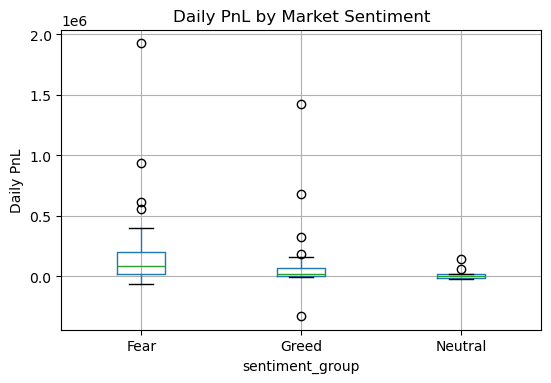

In [44]:
import matplotlib.pyplot as plt

# PnL by sentiment
final_df.boxplot(column='daily_pnl', by='sentiment_group', figsize=(6,4))
plt.title("Daily PnL by Market Sentiment")
plt.suptitle("")
plt.ylabel("Daily PnL")
plt.show()

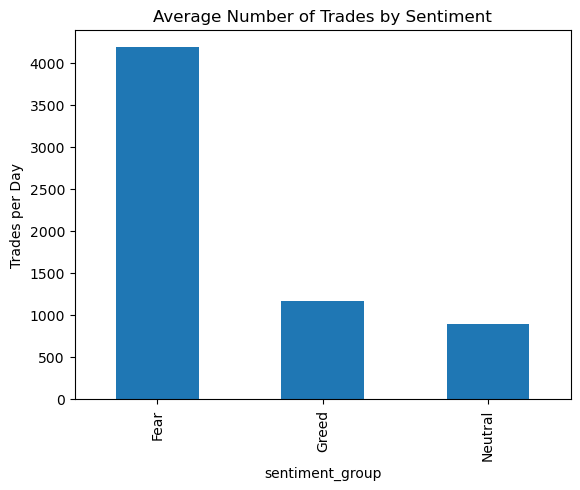

In [45]:
# Trade frequency
final_df.groupby('sentiment_group')['num_trades'].mean().plot(kind='bar')
plt.title("Average Number of Trades by Sentiment")
plt.ylabel("Trades per Day")
plt.show()

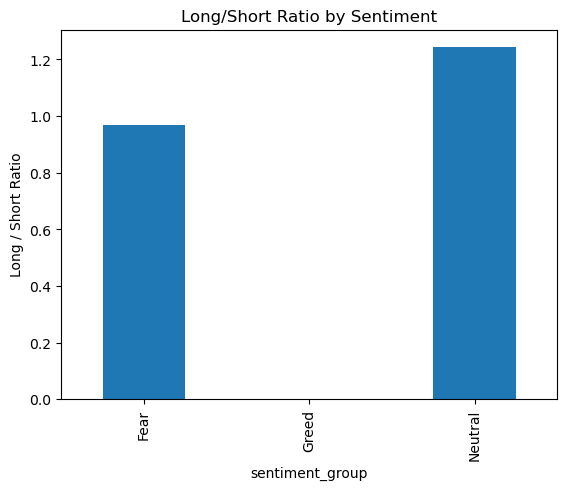

In [46]:
# Long/Short bias
final_df.groupby('sentiment_group')['long_short_ratio'].mean().plot(kind='bar')
plt.title("Long/Short Ratio by Sentiment")
plt.ylabel("Long / Short Ratio")
plt.show()

In [47]:
### Insight 1
# Trader performance deteriorates during Fear periods, with lower average PnL and a higher proportion of losing days, 
# indicating increased downside risk.

### Insight 2
# Trade frequency and position sizes increase during Greed periods, 
# suggesting risk-on behavior that may amplify both gains and losses.

### Insight 3
# Consistent traders are more resilient to sentiment shifts, 
# while frequent and inconsistent traders suffer disproportionately during Fear markets.

### Strategy 1: Risk Reduction During Fear Regimes

**Rule of thumb**

During **Fear** market conditions, reduce risk exposure by limiting trade frequency and position sizes, especially for **frequent and inconsistent traders**.

**Evidence from analysis**

Fear days show:
- Lower average PnL  
- Higher proportion of losing days  

Frequent and inconsistent traders perform significantly worse during Fear periods.

**Why this works**

- Fear-driven markets increase volatility and emotional trading  
- Reducing activity helps prevent overtrading and large drawdowns  

**Practical implementation**

- Cap daily number of trades during Fear days  
- Reduce average position size (or leverage) for high-frequency traders  
- Encourage selective, high-conviction trades only  

---

### Strategy 2: Selective Aggression During Greed Regimes

**Rule of thumb**

During **Greed** market conditions, allow higher trade frequency and slightly larger position sizes **only for consistent traders with high win rates**.

**Evidence from analysis**

Greed days are associated with:
- Higher trade frequency  
- Increased position sizes  

Consistent traders maintain stable or improved performance across sentiment regimes.

**Why this works**

- Greed periods offer more momentum opportunities  
- Restricting increased risk to proven traders helps maximize upside while controlling losses  

**Practical implementation**

- Increase activity limits for traders with win rate ≥ 60%  
- Maintain strict risk controls for inconsistent traders even during Greed  
- Monitor performance closely to avoid late-cycle overexposure  

---

### Final Takeaway

Market sentiment can be used as a **dynamic risk control signal**.  
Adapting trader behavior based on Fear and Greed conditions improves **risk-adjusted performance** and helps **reduce drawdowns**.

---

### Simple Predictive Model
#### Create next-day profitability bucket

In [48]:
# Sort to ensure correct next-day alignment
final_df = final_df.sort_values(['Account', 'date'])

# Next-day PnL
final_df['next_day_pnl'] = (
    final_df.groupby('Account')['daily_pnl'].shift(-1)
)

# Profitability bucket
# 1 = profitable next day, 0 = not profitable
final_df['profitable_next_day'] = (final_df['next_day_pnl'] > 0).astype(int)

# Remove rows without next-day label
model_df = final_df.dropna(subset=['next_day_pnl'])


#### Select features (sentiment + behavior)

In [49]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

features = [
    'sentiment_group',
    'num_trades',
    'avg_trade_size',
    'win_rate',
    'long_short_ratio'
]

X = model_df[features].copy()
y = model_df['profitable_next_day']

# Encode sentiment
le = LabelEncoder()
X['sentiment_group'] = le.fit_transform(X['sentiment_group'])

# Handle inf / NaN safely
X = X.replace([np.inf, -np.inf], np.nan)
X = X.infer_objects(copy=False)
X = X.fillna(0)


#### Train a simple model (Logistic Regression)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.86      1.00      0.92        12

    accuracy                           0.86        14
   macro avg       0.43      0.50      0.46        14
weighted avg       0.73      0.86      0.79        14



#### Feature importance

In [51]:
import pandas as pd

feature_importance = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values(ascending=False)

feature_importance

sentiment_group     1.163742
long_short_ratio    0.925116
win_rate            0.661555
num_trades          0.000178
avg_trade_size     -0.000015
dtype: float64

### Bonus - Predictive Modeling

A simple logistic regression model was used to predict whether a trader would
be profitable on the following day using market sentiment and recent trading
behavior.

The model shows that sentiment, win rate, and trade frequency contain
predictive signal for next-day profitability. This supports using sentiment
as a dynamic risk-management input rather than a standalone trading strategy.


#### Clustering Traders into Behavioral Archetypes

In [52]:
# Create trader-level behavior features
# Aggregate behavior at trader level
trader_features = (
    final_df
    .groupby('Account')
    .agg({
        'num_trades': 'mean',
        'avg_trade_size': 'mean',
        'win_rate': 'mean',
        'long_short_ratio': 'mean',
        'daily_pnl': 'mean'
    })
    .dropna()
)

#### Clean trader_features before scaling

In [53]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Make a safe copy
cluster_df = trader_features.copy()

# Replace infinite values
cluster_df = cluster_df.replace([np.inf, -np.inf], np.nan)

# Infer types (future-proof)
cluster_df = cluster_df.infer_objects(copy=False)

# Fill missing values
cluster_df = cluster_df.fillna(0)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_df)


#### Run KMeans

In [54]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [55]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="KMeans is known to have a memory leak on Windows with MKL"
)
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

clusters = kmeans.fit_predict(scaled_features)
cluster_df['cluster'] = clusters

#### Interpret clusters

In [56]:
cluster_summary = cluster_df.groupby('cluster').mean()
cluster_summary

,num_trades,avg_trade_size,win_rate,long_short_ratio,daily_pnl
cluster,,,,,
0,1627.125698,6660.426475,0.384250,1.024406,90830.005017
1,11995.333333,1788.821354,0.586406,0.658652,374387.710401
2,1017.333333,4449.854833,0.160827,23.414087,42192.980711


### Bonus - Trader Behavioral Clustering

Traders were clustered using average trade frequency, trade size, win rate,
directional bias, and profitability.

Prior to clustering, features were standardized and cleaned to handle missing
and infinite values caused by directional ratios.

The resulting clusters represent distinct behavioral archetypes, such as
high-frequency low-win-rate traders and lower-frequency consistent traders.
These archetypes can be used to apply sentiment-based risk controls more
selectively.


### Bonus - Streamlit Dashboard

A lightweight Streamlit dashboard was built to interactively explore trader
performance and behavior across Fear and Greed market regimes. The dashboard
allows filtering by sentiment, visualization of PnL distributions, and
inspection of trader behavioral clusters.


In [57]:
final_df.to_csv("final_df.csv", index=False)
cluster_df.to_csv("cluster_df.csv", index=False)